c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year origin  
0          70    usa  
1          70    usa  
2          70    usa  
3          70    usa  
4          70    usa  


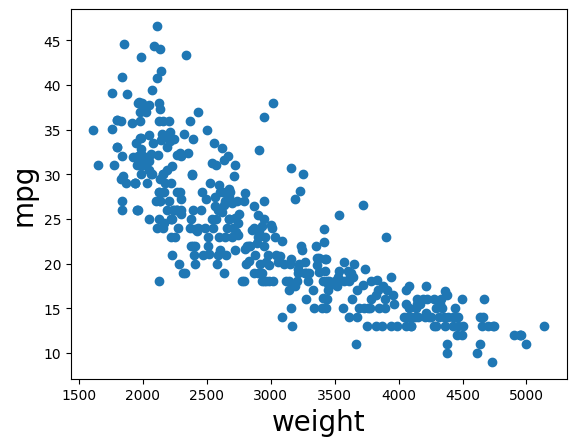

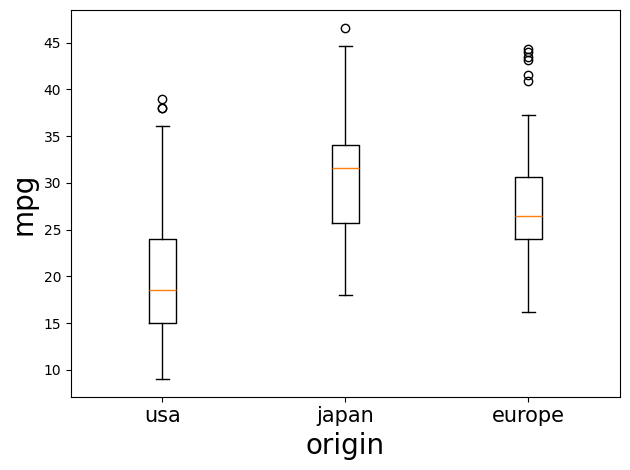

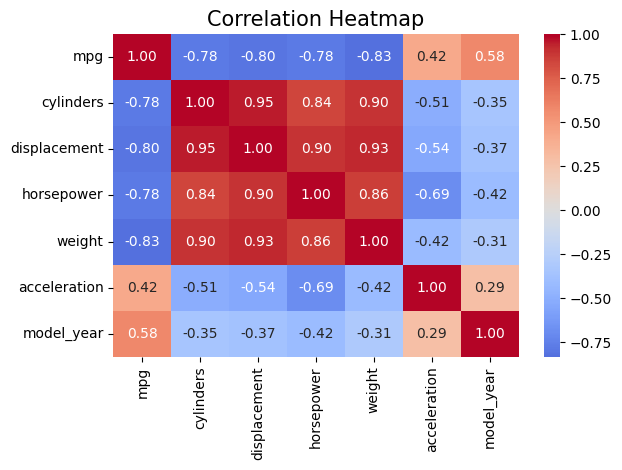

   cylinders  displacement  horsepower  weight  acceleration  model_year  \
0          8         307.0       130.0    3504          12.0          70   
1          8         350.0       165.0    3693          11.5          70   
2          8         318.0       150.0    3436          11.0          70   
3          8         304.0       150.0    3433          12.0          70   
4          8         302.0       140.0    3449          10.5          70   

   origin.usa  origin.japan  origin.europe  
0           1             0              0  
1           1             0              0  
2           1             0              0  
3           1             0              0  
4           1             0              0  


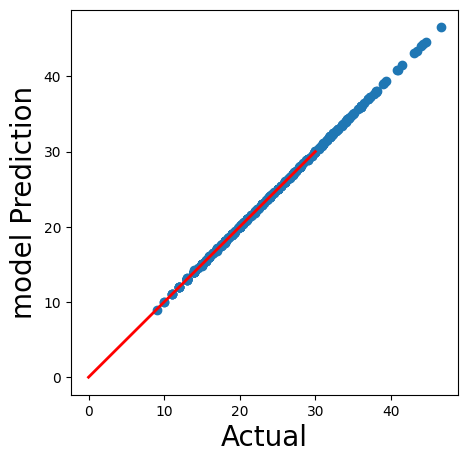

(398, 9)


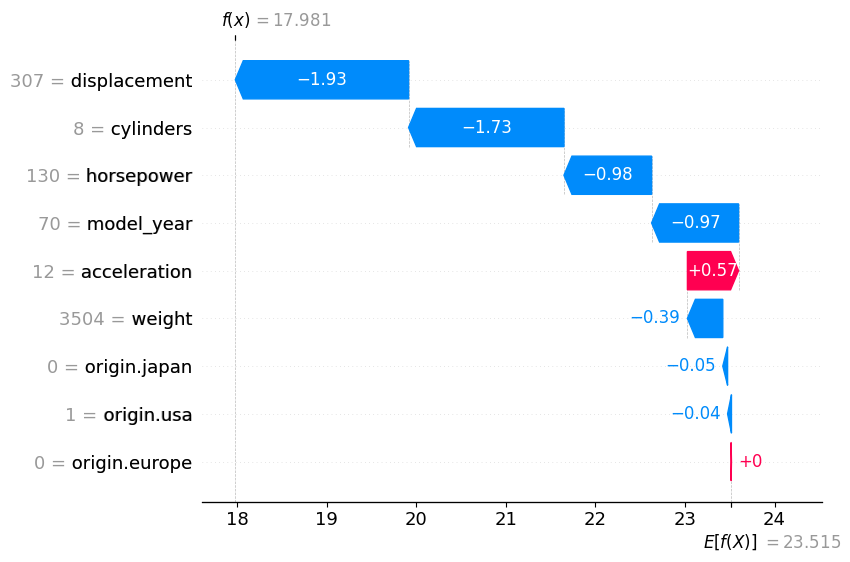

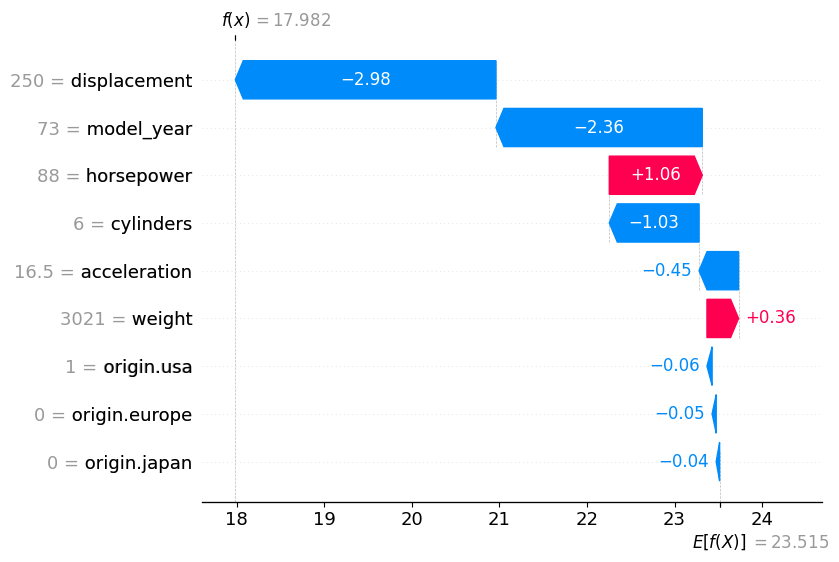

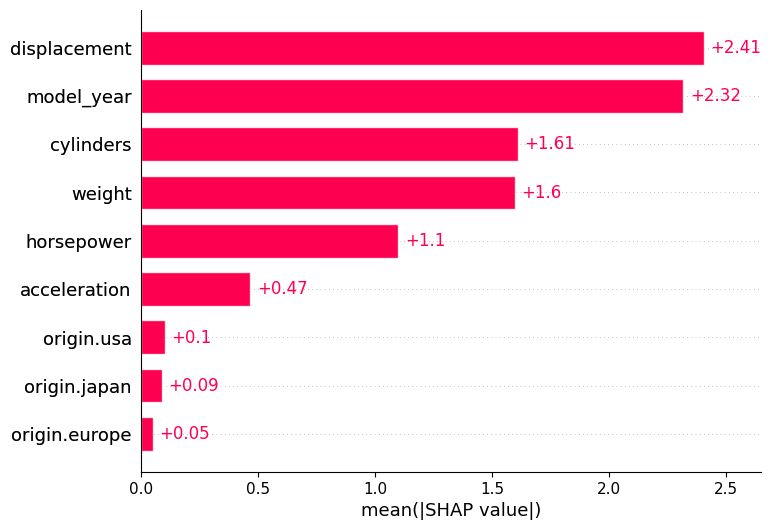

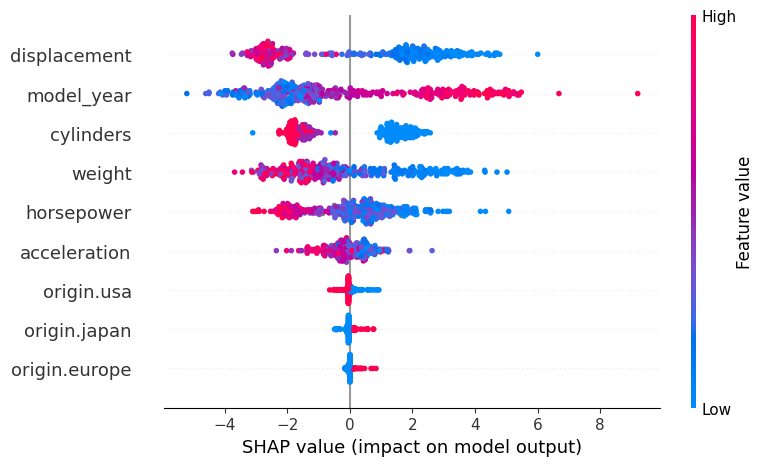

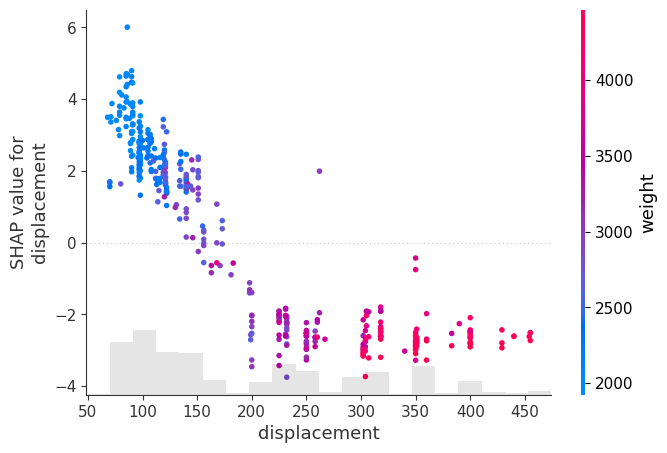

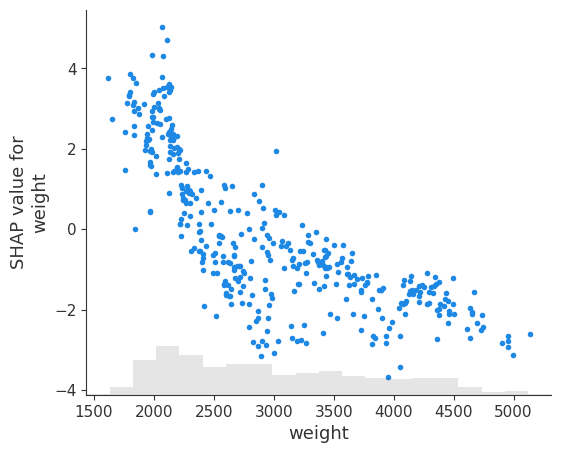

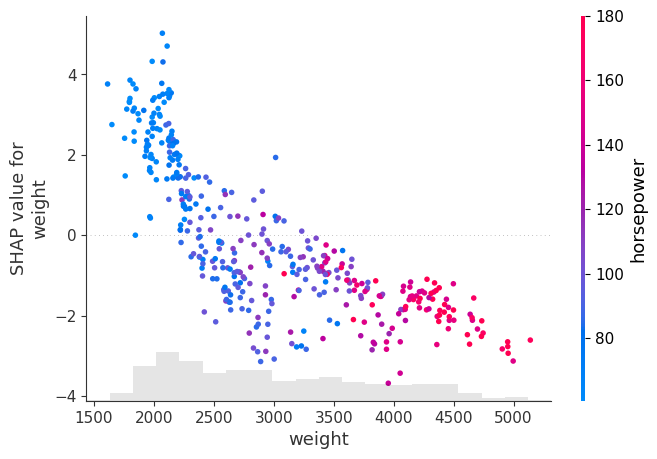

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap

shap.initjs()

# use the following url if csv file issue for whatever reason
# url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/refs/heads/master/mpg.csv"
# data = pd.read_csv(url, usecols=lambda column: column != "name")

data = pd.read_csv("mpg.csv", usecols=lambda column: column != "name")

# Check output first few rows
print(data.head())
# <IPython.core.display.HTML object>
#     mpg  cylinders  displacement  horsepower  weight  acceleration  model_year origin                       name
# 0  18.0          8         307.0       130.0    3504          12.0          70    usa  chevrolet chevelle malibu
# 1  15.0          8         350.0       165.0    3693          11.5          70    usa          buick skylark 320
# 2  18.0          8         318.0       150.0    3436          11.0          70    usa         plymouth satellite
# 3  16.0          8         304.0       150.0    3433          12.0          70    usa              amc rebel sst
# 4  17.0          8         302.0       140.0    3449          10.5          70    usa                ford torino

plt.scatter(data['weight'],data['mpg'])
plt.ylabel('mpg', size=20)
plt.xlabel('weight', size=20)
plt.show()

# Boxplot
plt.boxplot(data[data.origin=="usa"]["mpg"], positions=[1])
plt.boxplot(data[data.origin=="japan"]["mpg"], positions=[2])
plt.boxplot(data[data.origin=="europe"]["mpg"], positions=[3])
plt.xticks(ticks=[1,2,3], labels=['usa','japan','europe'], size=15)
plt.ylabel('mpg', size=20)
plt.xlabel('origin', size=20)
plt.tight_layout()
plt.show()

# Correlation Heatmap
cont = ["mpg","cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"]
corr_matrix = pd.DataFrame(data[cont],columns=cont).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center = 0, annot=True, fmt='.2f')
plt.title("Correlation Heatmap", fontsize=15)
plt.tight_layout()
plt.show()

y= data['mpg']
X = data[["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin"]]
X['origin.usa'] = [1 if s == 'usa' else 0 for s in X['origin']]
X['origin.japan'] = [1 if s == 'japan' else 0 for s in X['origin']]
X['origin.europe'] = [1 if s == 'europe' else 0 for s in X['origin']]
X=X.drop('origin', axis=1)
print(X.head())
#    cylinders  displacement  horsepower  weight  acceleration  model_year  origin.usa  origin.japan  origin.europe
# 0          8         307.0       130.0    3504          12.0          70           1             0              0
# 1          8         350.0       165.0    3693          11.5          70           1             0              0
# 2          8         318.0       150.0    3436          11.0          70           1             0              0
# 3          8         304.0       150.0    3433          12.0          70           1             0              0
# 4          8         302.0       140.0    3449          10.5          70           1             0              0


# Begin modelling
# Train the model
model=xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)

y_pred = model.predict(X)
plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred)
plt.plot([0, 30], [0,30], color='r', linestyle='-', linewidth=2)
plt.ylabel('model Prediction', size=20)
plt.xlabel('Actual', size=20)
plt.show()

explainer = shap.Explainer(model)
shap_values = explainer(X)
print(np.shape(shap_values.values))

# Plot shap feature values for the first instance in the dataset
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[100])

shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)


shap.plots.scatter(shap_values[:, "displacement"], color=shap_values[:, "weight"])

# Dependence plots
# Example of how to use SHAP for dependence plots
shap.plots.scatter(shap_values[:, "weight"])  # Scatter plot for the "weight" feature

# Dependence plots adding additional feature with color
shap.plots.scatter(shap_values[:, "weight"], color=shap_values[:, "horsepower"])  # Color by another feature


